# scRNAseq Data Analysis - Data Integration

# Setup

This notebook should introduce you to some typical tasks, using Scanpy eco-system.(https://scanpy.readthedocs.io/en/stable/tutorials.html).


Let's import the necessary packages and read in the Cellranger-formatted data folder output.

In [4]:
import scanpy as sc
import numpy as np
import re
import os
import pandas as pd
import seaborn as sb
import matplotlib
import scipy.sparse as sp
from scipy.sparse import issparse
import anndata2ri

import matplotlib as mpl
from scipy import stats as scistats
import matplotlib.pyplot as pl
import scanpy.external as sce
from matplotlib import colors
import bbknn
from pathlib import Path
from ipywidgets import interactive

sc._settings.ScanpyConfig.n_jobs=8

pl.rcParams['pdf.fonttype'] = 'truetype'
sc.set_figure_params(vector_friendly=False,dpi_save=300,transparent=True)
pl.rcParams['lines.linewidth'] = 0.1
sc.set_figure_params(color_map='viridis')
colorsComb = np.vstack([pl.cm.Reds(np.linspace(0, 1, 10)), pl.cm.Greys_r(np.linspace(0.7, 0.8, 0))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

import muon as mu
from muon import prot as pt

%matplotlib inline
import panel as pn
#pn.extension(sizing_mode="stretch_width", comms='colab')
pn.extension( comms='colab')


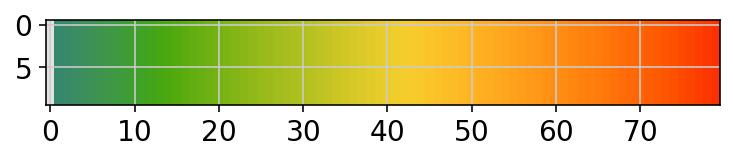

In [2]:
import colorcet as cc

xs, _ = np.meshgrid(np.linspace(0, 1, 80), np.linspace(0, 1, 10))
colorsComb = np.vstack([pl.cm.Greys_r(np.linspace(0.8,0.1, 1)), cc.cm.rainbow_bgyr_35_85_c72(np.linspace(0.2,1, 100))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
pl.imshow(xs, cmap=mymap);  # use tab completion to choose

In [3]:
# add extra code to the path
import sys
sys.path.append('/content/sctoolkit/sctoolkit/')
from proportions import *

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.


# PART 0. Reproducibility

In [5]:
%load_ext watermark
%watermark
%watermark --iversions -v -m -p numpy,scipy,sklearn,anndata,scanpy,muon,anndata2ri,rpy2

Last updated: 2022-07-13T17:17:46.958561+00:00

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 5.13.0-1031-aws
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

numpy     : 1.21.6
scipy     : 1.8.0
sklearn   : 0.0
anndata   : 0.7.8
scanpy    : 1.9.1
muon      : 0.1.2
anndata2ri: 1.1
rpy2      : 3.5.1

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 5.13.0-1031-aws
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

seaborn   : 0.11.2
matplotlib: 3.5.2
bbknn     : 1.5.1
sys       : 3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:25:59) 
[GCC 10.3.0]
colorcet  : 3.0.0
anndata2ri: 1.1
numpy     : 1.21.6
pandas    : 1.2.5
panel     : 0.13.1
logging   : 0.5.1.2
muon      : 0.1.2
scanpy    : 1.9.1
re        : 2.2.1
scipy   

# PART 1. Data merging 

# Setup data directory

In [6]:
data_dir = '/home/jovyan/work/public-data/MultiOME/

In [7]:
%cd /home/jovyan/work/

/home/jovyan/work


In [ ]:
#Change XXX to sample name
#folder='/content/'

yourname='Ceda'

samplename='Cell_Lines_all'
random_state=42

import os

if not os.path.exists('./figures/'):
    os.makedirs('./figures/')

# Load Sample1

shared-data/Multiome_Results/Brain/filtered_feature_bc_matrix/matrix.mtx.gz# import data as H5AD

public-data/scRNA/Cell_line2_JT_outs/filtered_feature_bc_matrix
Reading the matrix with cache enabled helps save time on I/O operations, which is particularly relevant for bigger datasets.

In [ ]:
adata1 = sc.read_10x_mtx(data_dir + "/Cell_line5_SH_outs/filtered_feature_bc_matrix/",cache = True)
adata1

In [ ]:
adata1.obs['sample']=['Cell_line_5']*adata1.n_obs
adata1.obs['group']=['SH']*adata1.n_obs
adata1

In [ ]:
sce.pp.scrublet(adata1,expected_doublet_rate = 0.05,threshold=0.4)

In [ ]:
sb.set_context('paper')
savefig=samplename + '_7_QC_doublets.pdf'
sce.pl.scrublet_score_distribution(adata1,save=savefig)

In [ ]:
adata1 = adata1[adata1.obs.predicted_doublet == False]
adata1

# Load Sample2

In [ ]:
adata2 = sc.read_10x_mtx(data_dir + "/Cell_line5_T7_outs/filtered_feature_bc_matrix/",cache = True)
adata2

In [ ]:
adata2.obs['sample']=['Cell_line_5']*adata2.n_obs
adata2.obs['group']=['T7']*adata2.n_obs
adata2

In [ ]:
sce.pp.scrublet(adata2,expected_doublet_rate = 0.05,threshold=0.4)

In [ ]:
sb.set_context('paper')
savefig=samplename + '_7_QC_doublets.pdf'
sce.pl.scrublet_score_distribution(adata2,save=savefig)

In [ ]:
adata2 = adata2[adata2.obs.predicted_doublet == False]
adata2

# Data Integration 

In [ ]:
adata=adata1.concatenate(adata2,join = "inner")
adata

Let's remove all genes expressed in fewer than 5 cells:

In [ ]:
sc.pp.filter_genes(adata, min_cells=5)
adata

In [ ]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

# compute qc metrics

regex = re.compile('^(MT-).*', re.IGNORECASE)
mito_genes = [l for l in adata.var_names for m in [regex.search(l)] if m]
print('Found {} mito genes and annotated.'.format(len(mito_genes)))
adata.var['mt'] = False
adata.var.loc[mito_genes, 'mt'] = True


#adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['rb'] = adata.var_names.str.startswith(('RPS','RPL'))  # annotate the group of ribosomal proteins as 'rb'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata, qc_vars=['rb'], percent_top=None, log1p=False, inplace=True)

adata

# Helper plots for determining gene and count threshold values

In [ ]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize=(16,4), gridspec_kw={'wspace':0.2})

ax1_dict = sb.histplot(adata.obs['n_counts'], kde=False, ax=ax1,)
ax2_dict =  sb.histplot(adata.obs['n_counts'][adata.obs['n_counts']<1000], kde=False, bins=60, ax=ax2,)
ax3_dict =  sb.histplot(adata.obs['n_counts'][adata.obs['n_counts']<5000], kde=False, bins=60, ax=ax3,)
ax4_dict = sb.histplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60, ax=ax4, )
savefig='figures/'+samplename + '_1_QC_counts_filtering.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

In [ ]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4), gridspec_kw={'wspace':0.2})

ax1_dict = sb.histplot(adata.obs['n_genes'], kde=False, bins=60, ax=ax1,)
ax2_dict =  sb.histplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60, ax=ax2,)
ax3_dict =  sb.histplot(adata.obs['n_genes'][adata.obs['n_genes']<5000], kde=False, bins=60, ax=ax3,)
savefig='figures/'+samplename + '_2_QC_gene_filtering.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

Plot correlations and make sure that high mitochondrial content corresponds with low total counts (dead cells), and that total counts have strong positive correlation with the number of expressed genes:

In [ ]:
# plot percentage of mitochondtial genes versus count depth and n_genes
sb.set_context('paper')
pl.rcParams['figure.figsize']=(5,5) #rescale figures
savefig=samplename + '_4_QC_saturationplot.pdf'
sc.pl.scatter(adata, x='total_counts', y='n_genes', color='group',save=savefig)

Filter outliers cells with >150,000 couts

In [ ]:
sc.pp.filter_cells(adata, max_counts = 150000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

High ribosomal protein content can correlate inversly with  with MT, and may contain biological information.( Do not apply to snRNASeq. Why?)

In [ ]:
sb.set_context('paper')
pl.rcParams['figure.figsize']=(5,5) #rescale figures
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_rb')
sc.pl.scatter(adata, x='pct_counts_rb', y='pct_counts_mt')

A violin plot of the computed quality measures can help us analyze the dataset in general and make decisions about cutoffs.

In [ ]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4), gridspec_kw={'wspace':0.2})

ax1_dict = sc.pl.violin(adata, 'n_counts', groupby='sample', size=0.5, log=True, cut=0, ax=ax1, show=False)
ax2_dict =  sc.pl.violin(adata, 'n_genes', groupby='group', size=0.5, log=True, cut=0, ax=ax2, show=False)
ax3_dict = sc.pl.violin(adata, 'pct_counts_mt', groupby='sample',size=0.5, ax=ax3, show=False,)
savefig='figures/'+samplename + '_5_QC_violin_plots.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

Let's show those genes that yield the highest fraction of counts in each single cell, across all cells.

In [ ]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
savefig='_'+samplename + '_6_QC_highest_expr_genes.pdf'
sc.pl.highest_expr_genes(adata, n_top=20,save=savefig,)

In [ ]:
print(adata.obs['group'].value_counts())

In [ ]:
adata.obs['n_counts'].sum()/adata.obs['group'].value_counts()

In [ ]:
adata.obs['n_counts'].sum()

# Interactive filtering

In [ ]:
def h(counts=1000, genes=500,mito=25):
    conditions = [(adata.obs['predicted_doublet'] == True),(adata.obs['n_genes_by_counts'] < counts),(adata.obs['n_genes'] < genes),(adata.obs['pct_counts_mt'] >mito),(adata.obs['pct_counts_mt'] <= mito) & (adata.obs['n_genes_by_counts'] >= counts) & (adata.obs['n_genes'] >= genes)& (adata.obs['predicted_doublet'] != True)]
    values = ['Doublet', 'Low_nFeature', 'Low_ngenes','High_MT', 'Passing']
    adata.obs['QC'] = np.select(conditions, values)
    adata.obs['QC'] = adata.obs['QC'].astype('category')

    new_df1=pd.DataFrame(adata.obs['QC'].value_counts()).reset_index()
    p=sb.barplot(x='index',y='QC',data=new_df1,color='sandybrown')
    show_values(p)


interactive_plot = interactive(h, counts=(0, 2000,20), genes=(0, 2000,20), mito=(0, 100, 1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

In [ ]:
adata.obs['QC'].value_counts()

## Plot QC for cells that pass tentative thresholds

In [ ]:

sb.set_context('paper')


fig, (ax1, ax2, ax3) = pl.subplots(1, 3, figsize=(6, 3), dpi=150, sharey=False)
adata.obs['n_genes']

sb.histplot( adata[adata.obs['QC'] == 'Passing'].obs['n_genes'], ax=ax1, kde=True, bins=100)
sb.histplot( adata[adata.obs['QC'] == 'Passing'].obs['n_counts'], ax=ax2, kde=True, bins=100)
sb.histplot(adata[adata.obs['QC'] == 'Passing'].obs['pct_counts_mt'], ax=ax3, kde=True, bins=100)

ax1.title.set_text('n_genes')
ax2.title.set_text('n_counts')
ax3.title.set_text('mt_pct')

fig.text(0.00, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()
savefig='figures/'+samplename + '_3_QC_filtering_postfilter.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

# PART 2. Normalization and dimensionality reduction.

Squre root of total-count normalize (library-size correct) the data matrix 𝐗 to 10,000 reads per cell, so that counts become comparable among cells. The data are also log-transformed with a pseudocount of 1. Transformed data is stored in 'sqrt_norm' layer

In [ ]:
adata.layers["raw"] = adata.X 
adata.raw=adata
adata.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(adata, inplace=False)["X"])

pearson residuals normalization used for Dimention reduction, stored in normalized

The comand will :
 * Calculate pearson residuals for each gene 
 * Identify highly-variable genes to prioritize in further analysis.
 * Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [ ]:
sc.experimental.pp.recipe_pearson_residuals(adata,n_top_genes=3000,n_comps=100,random_state=42,inplace=True)
adata.layers["normalized"]=adata.X

adata

Plot the highly variable genes, after the normalization.

In [ ]:
adata

In [ ]:
#markers = ["IL7R","LYZ","CD14","MS4A1","CD8A","GNLY","NKG7","FCGR3A","MS4A7","FCER1A","CST3","PPBP",]
markers = ["Th"]
hvgs = adata.var["highly_variable"]
fig, ax = plt.subplots(figsize=(6, 6))
pl.scatter(
        adata.var["mean_counts"], adata.var["residual_variances"], s=3, edgecolor="none"
    )
pl.scatter(
        adata.var["mean_counts"][hvgs],
        adata.var["residual_variances"][hvgs],
        c="tab:red",
        label="selected genes",
        s=3,
        edgecolor="none",
    )
pl.scatter(
        adata.var["mean_counts"][np.isin(adata.var_names, markers)],
        adata.var["residual_variances"][np.isin(adata.var_names, markers)],
        c="k",
        label="known marker genes",
        s=10,
        edgecolor="black",
    )
ax.set_xscale("log")
ax.set_xlabel("mean expression")
ax.set_yscale("log")
ax.set_ylabel("residual variance")
ax.set_title(samplename)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

# cellcycle score

 Let's calculate cell cycle scores, as described [here](https://nbviewer.jupyter.org/github/theislab/scanpy_usage/blob/master/180209_cell_cycle/cell_cycle.ipynb). 

import scanpy as sc
mito_gene_names = sc.queries.mitochondrial_genes("hsapiens")It is important to note that cell cycle analysis has to be done after normalization 

In [ ]:
s_genes = ['MCM5','PCNA','TYMS','FEN1','MCM7','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1',
           'UHRF1','CENPU','HELLS','RFC2','POLR1B','NASP','RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7',
           'POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2',
           'USP1','CLSPN','POLA1','CHAF1B','MRPL36','E2F8']
g2m_genes = ['HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B',
             'MKI67','TMPO','CENPF','TACC3','PIMREG','SMC4','CCNB2','CKAP2L','CKAP2','AURKB','BUB1',
             'KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','CDCA3','JPT1','CDC20','TTK','CDC25C',
             'KIF2C','RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1',
             'ANLN','LBR','CKAP5','CENPE','CTCF','NEK2','G2E3','GAS2L3','CBX5','CENPA']

cell_cycle_genes = s_genes + g2m_genes
display(len(s_genes))
display(len(g2m_genes))
display(len(cell_cycle_genes))

In [ ]:
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
len(cell_cycle_genes)

In [ ]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

In [ ]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

# PCA (Ploting only)

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

In [ ]:
#sc.pp.pca(adata, n_comps = 100, use_highly_variable =False, svd_solver = "arpack")
sc.pl.pca_variance_ratio(adata, n_pcs = 100,log=True)

UMAP and tSNE are popular methods used for dimensionality reduction and visualisation of very large datasets. UMAP is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories.

Plot the data with UMAP, with coloring according to clustering. Some larger clusters are clearly identifiable as cell populations. Other smaller clusters can be attributed to doublets, cell cycle artefacts, etc.

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
sc.pp.neighbors(adata, n_pcs=30,n_neighbors=10,random_state=42)

genes_to_plot = ['n_genes','n_counts','log_counts','pct_counts_mt','doublet_score']
sc.tl.umap(adata)
savefig=samplename+"_4_QC_doublets_vst_mito.pdf"
sc.pl.umap(adata, color = genes_to_plot,ncols=2,wspace=0.25, save=savefig)

Let's remove the cells that did not pass QC and compare plots. We can now see much more defined clusters. 

In [ ]:
adata

In [ ]:
adata = adata[adata.obs['QC'] == 'Passing']
adata

Our filtered dataset now contains 2036 cells, only 13 cells were removed!

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
savefig=samplename+"_4_QC_doublets_vst_mito.pdf"
sc.pl.umap(adata, color = genes_to_plot,ncols=2,layer='counts',save=savefig)

# PART 3. Normalization and careful clustering of the cleaned dataset.

Let's restart our analysis from the counts matrix again

In [ ]:
adata.X=adata.layers['raw']

Let's redo HVG, PCA, UMAP, and clustering analysis, since now we have QC-filtered cells.

In [ ]:
#HVG
sc.experimental.pp.highly_variable_genes(adata, flavor="pearson_residuals", n_top_genes=2000)

In [ ]:
# Nomalization
sc.experimental.pp.normalize_pearson_residuals(adata,inplace=True)
adata.layers["normalized"]=adata.X

In [ ]:
#PCA
sc.pp.pca(adata, n_comps=100,random_state=42)

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
sc.pp.neighbors(adata, n_pcs=30,n_neighbors=15,random_state=42)

#genes_to_plot = ['n_genes','log_counts','pct_counts_rb','phase']
genes_to_plot = ['n_genes','log_counts','pct_counts_rb','phase']

sc.tl.umap(adata,random_state=42)
savefig=samplename+"_4_QC_doublets_vst_mito.pdf"
sc.pl.umap(adata,wspace=0.25, color = genes_to_plot,ncols=2,save=savefig)

In [ ]:
%%capture
sc.tl.leiden(adata,random_state=random_state,resolution=1.5, key_added='leiden_r1.5')
sc.tl.leiden(adata,random_state=random_state,resolution=1, key_added='leiden_r1')
sc.tl.leiden(adata,random_state=random_state, resolution=0.8, key_added='leiden_r0.8')
sc.tl.leiden(adata,random_state=random_state, resolution=0.5, key_added='leiden_r0.5')
sc.tl.leiden(adata,random_state=random_state, resolution=0.4, key_added='leiden_r0.4')
sc.tl.leiden(adata,random_state=random_state, resolution=0.3, key_added='leiden_r0.3')
sc.tl.leiden(adata,random_state=random_state, resolution=0.2, key_added='leiden_r0.2')

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
#sc.tl.leiden(adata,random_state=random_state, resolution = 0.5)
savefig=samplename+"_clustering_lores_vst.pdf"
sc.pl.umap(adata, color=['leiden_r0.2','sample','leiden_r0.4'], legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',frameon=False,save=savefig)

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
#sc.tl.leiden(adata,random_state=random_state, resolution = 0.5)
savefig=samplename+"_clustering_hires_vst.pdf"
sc.pl.umap(adata, color=['leiden_r0.5','leiden_r0.8','leiden_r1.5'], legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',frameon=False,save=savefig)

If UMAP looks slightly less than perfect, we can use the following trick from the `scanpy` tutorial page:

In [ ]:
sc.tl.paga(adata,groups='leiden_r0.2')
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(7,7)
savefig=samplename+"_5_clustering_vst_lowres.pdf"
sc.pl.umap(adata, color=['leiden_r0.2','group'],ncols=3,legend_fontoutline=3, legend_fontweight='normal',frameon=False,save=savefig)

# PART 5. Data Integration (Batch Correction)

## Harmony 

In [ ]:
pip install harmonypy

In [ ]:
import scanpy.external as sce

In [ ]:
import harmonypy as hm

In [ ]:
# Prepare metadata and PCA
meta_data = adata.obs
data_mat = adata.obsm["X_pca"]

In [ ]:
ho = hm.run_harmony(data_mat, meta_data, "group")

In [ ]:
# Mapping back the result to the adata object
adata.obsm["X_pca"] = ho.Z_corr.T

# Build KNN and run UMAP
sc.pp.neighbors(adata, n_pcs =30)
sc.tl.umap(adata)

# Plotting UMAP
sc.pl.umap(adata, color=["group"])



## BBKNN

https://bbknn.readthedocs.io/en/latest/#PCA
sc.pp.pca(adata, n_comps=100,random_state=42)

In [ ]:
#PCA
sc.pp.pca(adata, n_comps=100,random_state=42)

In [ ]:
sce.pp.bbknn(adata,batch_key='group', n_pcs = 100)

In [ ]:
genes_to_plot = ['n_genes','log_counts','mt_frac']
sc.tl.umap(adata,random_state=42)
# Plotting UMAP
sc.pl.umap(adata, color=["group"])

# Transcription factor activity inference
## based on pseudobulk analysis


In [ ]:
pip install git+https://github.com/saezlab/dorothea-py.git 

In [ ]:
import dorothea

In [ ]:
# select the layer for the calculations
#adata.X=adata.layers["counts"]
adata.X=adata.layers["raw"]
adata.raw = adata

In [ ]:
# Read Dorothea Regulons for Human or Mouse
dorothea_mouse = dorothea.load_regulons(organism='Human')

# Compute SCIRA scores
dorothea.run(adata, dorothea_mouse, center=True, scale=True)

In [ ]:
tf_adata = dorothea.extract(adata)

In [ ]:
sc.tl.rank_genes_groups(tf_adata, groupby='group', method='wilcoxon')

In [ ]:
cell_types = np.unique(tf_adata.obs['group'])
top_tfs = []
for cell_type in cell_types:
    top_tf = sc.get.rank_genes_groups_df(tf_adata, cell_type).loc[0]['names']
    top_tfs.append(top_tf)

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(10,15)
sc.pl.rank_genes_groups_matrixplot(tf_adata, n_genes=5, vmin=-5, vmax=5, cmap='coolwarm')

# PART 6. Signature Enrichment

In [ ]:
markers={'CD14 Monocytes': ['S100A8','S100A9',],
 'CD4 naive': ['DNAJB1','FYB1',]}


In [ ]:
marker_labels = list(set(markers))

In [ ]:
for ix, clust in enumerate(marker_labels):
  geneset=markers[clust]
  sc.tl.score_genes(adata, geneset, ctrl_size=500, use_raw=False,score_name=clust)

In [ ]:
pl.rcParams['figure.figsize']=(4,4)
savefig=samplename+"_markers_HCA.pdf"
sc.pl.umap(adata, color=marker_labels,sort_order=True,vmin=0.3, vmax='p99.9',color_map=mymap,save=savefig)

# PART 7. Differential expression and marker selection.

After we have fixed the clusters, let's make gene markers using Wilcoxon test. Score plotting for each cluster allows to estimate the relative information of a marker in a quick fashion.

# Marker genes

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(4,4)
sc.tl.rank_genes_groups(adata, 'sample', method='wilcoxon',layer='sqrt_norm',key_added = "wilcoxon",use_raw=False)
sc.pl.rank_genes_groups(adata, n_genes=15,key="wilcoxon", sharey=False)

lets get a table with the marker genes 

In [ ]:
#method : {‘logreg’, ‘t-test’, ‘wilcoxon’, ‘t-test_overestim_var’} | None (default: None)
sc.tl.rank_genes_groups(adata, 'sample', method='wilcoxon',n_genes=adata.shape[1],layer='sqrt_norm',key_added = "wilcoxon",use_raw=False)
markers=pd.DataFrame(adata.uns['wilcoxon']['names']).head(10)
markers

In [ ]:
markers.to_csv('cellline_markers.csv')

In [ ]:
glist=sc.get.rank_genes_groups_df(adata, group='Cell_line_2', key='wilcoxon',log2fc_min=5,pval_cutoff=0.05)['names'].squeeze().str.strip().tolist()
print(len(glist))

In [ ]:
glist

Lets visualize some markers genes

In [ ]:
sb.set_context('paper')
pl.rcParams['figure.figsize']=(4,4) #rescale figures
savefig=samplename+"_10_markers_1.pdf"
sc.pl.umap(adata=adata, color=['Fth1','Psma7','Pde4dip','Tcf4','Ttn','S100a4','Bicc1','Arhgap15'],color_map=mymap,vmin='p20', vmax='p99.9',ncols=4,
           legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',use_raw=False,layer="sqrt_norm", save=savefig)

# Manual Annotation



 Using [panglaodb](https://panglaodb.se/search.html).  and other tools like [enrichR](https://maayanlab.cloud/Enrichr/) annotated the cluster

In [ ]:
adata.obs['annotated'] = adata.obs['leiden_r0.2'].cat.add_categories([ "Dendritic Cells"])
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['3','1'])] = 'Dendritic Cells'


adata.obs['annotated'] = adata.obs['annotated'].cat.remove_unused_categories()

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(7,7)
#sc.tl.leiden(adata,random_state=random_state, resolution = 0.5)
savefig=samplename+"_annotated_hires_annotated.pdf"
sc.pl.umap(adata, color=['annotated'], legend_loc='on data',cmap=mymap,legend_fontoutline=3,vmax='p99.9',legend_fontsize='small', legend_fontweight='normal',frameon=False,save=savefig)

#sample composition

In [ ]:
 fig=plot_proportion_barplot_with_ncells(
    adata,
    'group',
    fill='annotated', 
    fill_breakdown=None,
    yaxis_label=None,
    fill_label='annotated',
    percent_limit=1., 
    show_percent=True,
    height_scale=1., 
    width_scale=1.,
    legend_position=(-0, 0.5),
    normalize_by=None,)
fig.savefig('cell_composition_by_FOV.pdf', dpi=300, bbox_inches='tight')

In [ ]:
enr_res = gseapy.enrichr(gene_list=glist,
                     organism='Mouse',
                     gene_sets=Geneset,
                     description='pathway',
                     cutoff = 0.5)
gseapy.barplot(enr_res.res2d,title=Geneset,save=Geneset)

# save the annotated h5ad object

In [ ]:
adata.write(samplename+'_'+ yourname +'_'+ 'annotated.h5ad')